## GA Capstone Project
# TensorFlow Speech Recognition Challenge
This notebook builds a light-weight CNN to address the TensorFlow Speech Recognition Challenge. BingQuing Wei and DavidS provided the audio to spectrogram insight along with the initial Keras CNN insight.

The original training set wave files are sampled at 16000. To cut down on processing time they are resampled at a rate of 8000.

Current best LB is 0.73. Epoch set to 10. (Sample rate halfed to 8000 from 16000)

Link: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge



## File Structure
The current file strucuture for running this notebook:

speechCap

├── test            

│   └── audio #test wavfiles

├── train           

│   ├── audio #train wavfiles

└── model #store models

│

└── out #store sub.csv

## Techniques to improve the current score
This is a light model for quick scoring. Improvements will come by:

1. Use original wav files instead resampled ones.
2. Create more 'silence' wav files using chop_audio.
3. Build deeper CNN or use RNN.
4. Train for longer epochs
5. Use Transfer Learning - take a NN that has been trained on a similar data set, and retrain the last few layers of the network for new categories.
6. Vary the hyperparameters:
 - Train for additional epochs
 - Try dropout rates btw 0.2 - 0.35
 - Try SGD and other optimization functions
 - Vary the learning rate (lower learning rate = reliable but long training. Higher learning rate = training may not converge or may overshoot but training will be faster.)

## TensorFlow tutorial 
The baseline for the TensorFlow tutorial is 0.88.
Link: https://www.tensorflow.org/versions/master/tutorials/audio_recognition


## Appendix
__BingQing Wei__ provided excellent insight with his notebook on this data.

In [26]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc

from keras import optimizers, losses, activations, models
# Core layers and Convolutional layers that help train on image data
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras

import matplotlib.pyplot as plt
%matplotlib inline

The original sample rate is 16000, and we will resample it to 8000 to reduce data size.

In [22]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders`
#root_path = r'..'
root_path = r'.'
out_path = r'./out'
model_path = r'./model'
train_data_path = os.path.join(root_path, 'train', 'audio')
test_data_path = os.path.join(root_path,  'test', 'audio')

print(train_data_path)    #debug
print(test_data_path)     #debug

.\train\audio
.\test\audio


# EDA - sample spectrogram
- one example for 'yes' audio file

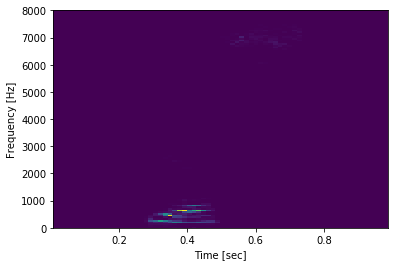

In [30]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_data_path) + filename)
frequencies, times, spectogram = signal.spectrogram(samples, sample_rate)


plt.pcolormesh(times, frequencies, spectogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

custom_fft and log_specgram functions. These were written by __DavidS__.
Taking the audio files and converting them to images for analysis by CNN.

In [14]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Following is the utility function to grab all wav files inside train data folder.

In [15]:
# my test of this function

def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
   # pat = r'.+/(\w+)/\w+\.' + ext + '$'
    pat = r'(\w{1,})'
    print(pat)
    labels = []
    #print(fpaths)        #debug
    for fpath in fpaths:
        r = re.findall(pat, fpath)
        #print(r)     #debug ==>> this is always 'NONE'..so no labels and no fnames
        if r:
            labels.append(r[2])      # append the label
            
    #pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        #r = re.match(pat, fpath)
        r = re.findall(pat, fpath)
        if r:
            newfile = r[3] + '.' + r[4]
            #fnames.append(r[3])
            fnames.append(newfile)
    return labels, fnames

#test
#labels, fnames = list_wavs_fname(train_data_path)      #debug
#print('==>Labels <==')
#print(labels)     #debug
#print('==>File names <==')
#print(fnames)     #debug

__pad_audio__ will pad audios that are less than 16000(1 second) with 0s to make them all have the same length.

__chop_audio__ will chop audios that are larger than 16000(eg. wav files in background noises folder) to 16000 in length. In addition, it will create several chunks out of one large wav files given the parameter 'num'.

__label_transform__ transform labels into dummies values. It's used in combination with softmax to predict the label.

In [5]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

Next, we use functions declared above to generate x_train and y_train.
label_index is the index used by pandas to create dummy values, we need to save it for later use.
i.e. reads in the .wav files and processes them in to spectograms.

In [6]:
labels, fnames = list_wavs_fname(train_data_path)
print(train_data_path)     #debug
#print(labels)      #debug
#print(fnames)      #debug

new_sample_rate = 8000
#new_sample_rate = 16000     # keep original sample rate
y_train = []
x_train = []

for label, fname in zip(labels, fnames):
    #print("=> train path, label, file name") #debug
    #print(train_data_path, label, fname)    #debug
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    #print(sample_rate, samples)     #debug
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train.append(label)
        x_train.append(specgram)
x_train = np.array(x_train)
x_train = x_train.reshape(tuple(list(x_train.shape) + [1]))
y_train = label_transform(y_train)
label_index = y_train.columns.values
y_train = y_train.values
y_train = np.array(y_train)

del labels, fnames
gc.collect()

.\train\audio
(\w{1,})
.\train\audio


C:\Users\IBM_ADMIN\Miniconda3\envs\GA\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


7

In [11]:
# my debug box
print(x_train.shape)
print(y_train.shape)   # 64,841 samples... 12 dimensional matrix

(58356, 99, 161, 1)
(58356, 12)


CNN declared below.
The specgram created will be of shape (99, 81), but in order to fit into Conv2D layer, we need to reshape it.

In [8]:
#input_shape = (99, 81, 1)             # 3D tensor
input_shape = (99, 161, 1)             # for 16,000 sample rate
nclass = 12                           # number of labels
inp = Input(shape=input_shape)
norm_inp = BatchNormalization()(inp)
# 8 = num of convolution filters, 2 = num of rows (& columns)for each convo kernel
# step size is (1,1) by default. 'subsample' to change it.
# n'relu' activation is performant cheap. NN runs faster.
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(norm_inp)
img_1 = Convolution2D(8, kernel_size=2, activation=activations.relu)(img_1)
# Reduce the num of parameters in the model
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)           # vertical, horizontal dimensions
# To reduce over-fitting
img_1 = Dropout(rate=0.2)(img_1)                        # fraction of units to drop. increase for more dropout
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = Convolution2D(16, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
img_1 = MaxPooling2D(pool_size=(2, 2))(img_1)
img_1 = Dropout(rate=0.2)(img_1)
img_1 = Flatten()(img_1)                            # Flatten the weights before passing to Dense output layer

# First param (128) is the output size of the layer
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
# Final layer has output of 12 - same as our label count
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

# Two args required to comile model
model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam()

# 1st try
#model.compile(optimizer=opt, loss=losses.binary_crossentropy)
#model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=[]'accuracy'])
# 2nd try - change to categorical_crossentropy
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=2017)
model.fit(x_train, y_train, batch_size=16, validation_data=(x_valid, y_valid), epochs=10, shuffle=True, verbose=2)

model.save(os.path.join(model_path, 'cnnCategoricalEpoch10Drop02S16.model'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 161, 1)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 161, 1)        4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 160, 8)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 159, 8)        264       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 79, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 79, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 77, 16)        1168      
__________

Test data is way too large to fit in RAM, we need to process them one by one.
Generator test_data_generator will create batches of test wav files to feed into CNN.

In [9]:
def test_data_generator(batch=16):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
            yield fnames, imgs
    if i < batch:
        imgs = np.array(imgs)
        imgs = imgs.reshape(tuple(list(imgs.shape) + [1]))
        yield fnames, imgs
    raise StopIteration()

We use the trained model to predict the test data's labels.
However, since Kaggle doesn't provide test data, the following sections won't be executed here.

In [10]:
#exit() #delete this
#del x_train, y_train
#gc.collect()

index = []
results = []
for fnames, imgs in test_data_generator(batch=32):
    predicts = model.predict(imgs)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)

df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'subCEepoch10Drop02.csv'), index=False)

C:\Users\IBM_ADMIN\Miniconda3\envs\GA\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: generator 'test_data_generator' raised StopIteration
  import sys
